<a href="https://colab.research.google.com/github/wwidjaja0/ucla-ajl-7/blob/main/UCLA_AJL_Team_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UCLA AJI Team 7**



---


**Resources and Documents:**  
[Notion](https://www.notion.so/team/18610071-e06a-812f-98e5-004281f76263/join) | [Google Drive](https://drive.google.com/drive/folders/1uNRJqQwA9hGX1WO9Tq-dfMP-ASt_dR5L?usp=sharing) | [Github Repo](https://github.com/wwidjaja0/ucla-aji-7)

---

**Summary**

## **How to contribute to this Colab**
Every time you make contributions/changes to this file, please follow the steps below for version control.

### 1. Click save a copy in GitHub

![saveacopy.png](https://i.imghippo.com/files/GqN7306fLg.png)

### 2. MAKE SURE YOU'RE SAVING IT TO THE RIGHT REPO (it should be <your username>/ucla-ajl-7)
### 3. Feel free to add a commit message to let others know/for documentation what you changed/did.

![commit.png](https://i.imghippo.com/files/JOJ9352xYs.png)

## **1. Setup Data**

### File Structure Setup + Kaggle API Connection

In [15]:
! pip install -q kaggle # install kaggle library

In [29]:
# Upload your kaggle.json to access the Kaggle API from your account:
from google.colab import files
import os
import kaggle

if not os.path.exists('./kaggle.json'):
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json

In [17]:
if not os.path.exists('./train.csv'):
  ! kaggle competitions download -c bttai-ajl-2025 # Attempt to download the bttai-ajl-2025.zip
  ! unzip -q bttai-ajl-2025.zip # unzip the downloaded competition folder

In [18]:
if os.path.exists('./bttai-ajl-2025.zip'):
  ! rm bttai-ajl-2025.zip # cleanup
if os.path.exists('./sample_data/'):
  ! rm -rf sample_data # cleanup

### Generate Pandas Dataframes from train/test CSV files

In [19]:
import pandas as pd

# Load the data
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [20]:
# Check the first few rows to understand the structure
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


## **2. Analyzing the Data**

In [21]:
!ls train/train/

acne				  dyshidrotic-eczema  melanoma
acne-vulgaris			  eczema	      mycosis-fungoides
actinic-keratosis		  epidermal-nevus     prurigo-nodularis
basal-cell-carcinoma		  folliculitis	      pyogenic-granuloma
basal-cell-carcinoma-morpheiform  kaposi-sarcoma      seborrheic-keratosis
dermatofibroma			  keloid	      squamous-cell-carcinoma
dermatomyositis			  malignant-melanoma  superficial-spreading-melanoma-ssm


In [22]:
# Number of images in each directory
training_folder = "./train/train/"
labels = [folder_name for folder_name in os.listdir(training_folder)]


for folder_name in labels:
  print(f"Number of {folder_name}:", len(os.listdir(training_folder + folder_name)))

Number of prurigo-nodularis: 119
Number of acne: 128
Number of eczema: 143
Number of mycosis-fungoides: 127
Number of basal-cell-carcinoma: 328
Number of folliculitis: 239
Number of superficial-spreading-melanoma-ssm: 83
Number of keloid: 109
Number of dyshidrotic-eczema: 58
Number of basal-cell-carcinoma-morpheiform: 43
Number of acne-vulgaris: 234
Number of seborrheic-keratosis: 48
Number of melanoma: 181
Number of dermatofibroma: 55
Number of dermatomyositis: 106
Number of squamous-cell-carcinoma: 407
Number of pyogenic-granuloma: 79
Number of actinic-keratosis: 122
Number of kaposi-sarcoma: 109
Number of epidermal-nevus: 64
Number of malignant-melanoma: 78


### Visualize a random sample of the data to analyze bias

In [23]:
import keras

image_size = (180, 180)  # Target dimensions for resizing images (height, width).
batch_size = 32  # Number of images processed in a single batch during training.
# Note: A batch size of 128 (common in other setups) may exceed Colab's memory limits, causing crashes.
# The chosen batch size of 32 balances memory usage and runtime, with an estimated runtime of ~3 hours.

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./train/train/",       # Path to the directory containing the dataset.
    validation_split=0.2,    # Specify that 20% of the dataset will be used for validation.
    subset="both",           # Create both training and validation datasets from the directory.
    seed=42,                 # Random seed to ensure reproducibility when shuffling the data.
    image_size=image_size,   # Resize all images to the specified dimensions (180x180).
    batch_size=batch_size,   # Divide the dataset into batches of the specified size (32 images per batch).
)

Found 2860 files belonging to 21 classes.
Using 2288 files for training.
Using 572 files for validation.


tf.Tensor(
[ 6 13  1 16  8  2  3 14  3  8 19 14  7 10 12 15  6 19 11 10 14  0 14  2
 19 18 19 10 17 10 12 10], shape=(32,), dtype=int32)


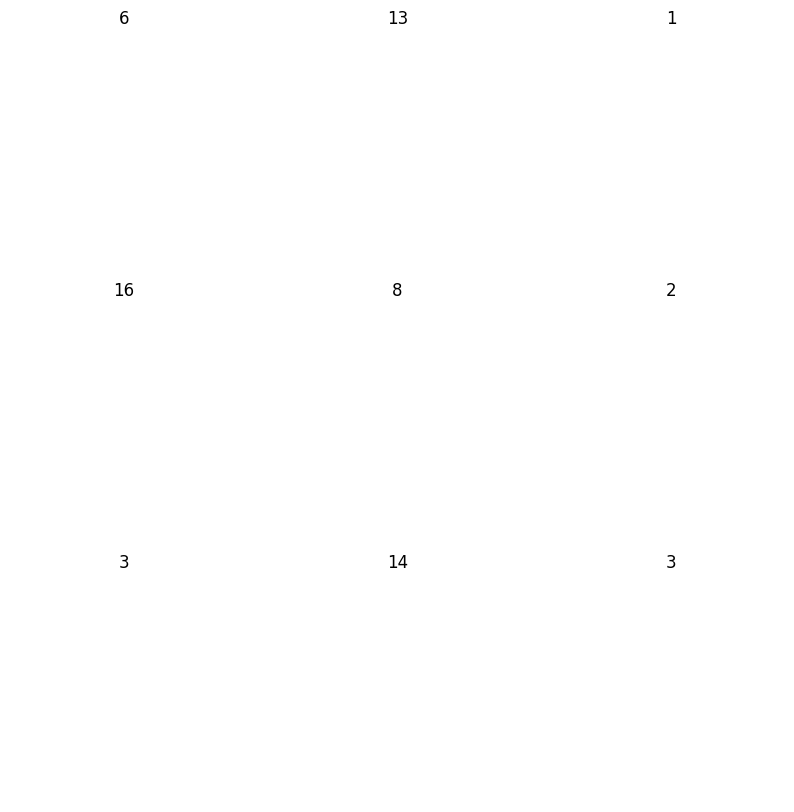

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(str(int(labels[i])))
        plt.axis("off")

## **3. Data Preprocessing**

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = './train/train/'

In [27]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [28]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 2288 non-validated image filenames.
Found 572 non-validated image filenames.


## **4. Build Model**

In [49]:
# 1. Import Necessary Libraries
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.

"""
From: Evaluating Deep Neural Networks Trained on Skin Images with the Fitzpatrick 17k Dataset (Full)

dataloaders, dataset_sizes = custom_load(
  256,
  20,
  "{}".format(train_path),
  "{}".format(test_path))
model_ft = models.vgg18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
model_ft.classifier[6] = nn.Sequential(
  nn.Linear(4096, 256),
  nn.ReLU(),
  nn.Dropout(0.4),
  nn.Linear(256, len(label_codes)),
  nn.LogSoftmax(dim=1))

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(),
  transforms.RandomHorizontalFlip(),
  transforms.CenterCrop(size=224), # Image net standards
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                       [0.229, 0.224, 0.225])
])
"""

## **5. Train Model**

In [ ]:
# TODO: Train your model here.

## **6. Make Predictions on Test Data**

In [ ]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    # test_datagen = ImageDataGenerator(rescale=1./255)
    # test_generator = test_datagen.flow_from_dataframe(
    #     .... ## set the test_generator here
    # )
    # return test_generator
    test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col="md5hash",  # Ensure this column exists in test_df
        target_size=(224, 224),  # Match model input size
        batch_size=16,  # Adjust batch size based on memory
        class_mode=None,  # No labels since we are predicting
        shuffle=False  # Keep order for correct mapping
    )

    return test_generator

In [ ]:
# Load test data
# test_dir = data_path + '/bttai-ajl-2025/test/test/'
# # test_generator = preprocess_test_data(test_df, test_dir)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.applications import EfficientNetB0

# First define any custom classes/functions if needed
class Cast(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Cast, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

# Register custom objects, this is neeeded for the model I found, we will change this in the future
custom_objects = {
    'Cast': Cast,
    'EfficientNetB0': EfficientNetB0,
}

# Update the custom objects registry
get_custom_objects().update(custom_objects)

# Load the model with custom objects
model = load_model(
    "/content/mobilenetv2_baseline.h5",
    custom_objects=custom_objects
)

test_dir = os.path.join(data_path, 'bttai-ajl-2025/test/test/')
test_generator = preprocess_test_data(test_df, test_dir)
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_df["predictions"] = predicted_labels

## **7. Generate Predictions**

In [ ]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission

# Load the sample submission file
sample_submission = pd.read_csv("./sample_submission.csv")

# Generate predictions
predictions = model.predict(test_generator)  # Output is a probability distribution

# Convert probabilities to class indices
predicted_indices = np.argmax(predictions, axis=1)  # Get the index of the highest probability

# Convert indices back to class names using label encoder
predicted_labels = label_encoder.inverse_transform(predicted_indices)  # Convert to class names

# Ensure predictions match the format of sample_submission
submission = sample_submission.copy()
submission.iloc[:, 1] = predicted_labels  # Assign class names

# Save the corrected predictions to CSV
submission.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv with class labels!")